In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks');
current_colors = sns.color_palette()
from scipy.optimize import minimize
from scipy.optimize import brentq

# Loading the data

In [2]:
def find_mut_pos(mutation):
    mut_list = mutation.split(':')
    return map(lambda x: 20-int(x[:-1]), mut_list)

In [3]:
data = pd.read_csv('../Data_Boyle/second_fit_data.summarized.off.10nM.rep1.txt',delimiter='\t')
data.drop(['p5', 'p95'], axis=1, inplace=True)
data = data[data['nmut']==2]
data= data[data['seq'].apply(lambda x: x[-2:]=='GG')]
data['slope'] = -1000*data['slope']
data['se'] = 1000*data['se']
data['se2'] = data['se']**2
data['MM_pos'] = data['mutations'].apply(find_mut_pos)
data = data[data['MM_pos'].apply(lambda x: x[1]>0)]
data = data[data['MM_pos'].apply(lambda x: (x[0]-x[1])==1)]
data['1st_MM_pos'] = data['MM_pos'].apply(lambda x: x[1])
data.rename(columns={'slope': 'off_rate ($10^{-3}$ Hz)'}, inplace=True)

In [4]:
data_2MM = data[['1st_MM_pos', 'off_rate ($10^{-3}$ Hz)']].groupby('1st_MM_pos', ).mean()
data_2MM['se'] = ((data[['1st_MM_pos', 'se2']].groupby('1st_MM_pos').sum())/(data[['1st_MM_pos', 'se2']].groupby('1st_MM_pos').count())).apply(np.sqrt)
data_2MM.reset_index(inplace=True)
data_2MM = data_2MM[data_2MM['1st_MM_pos']>5]

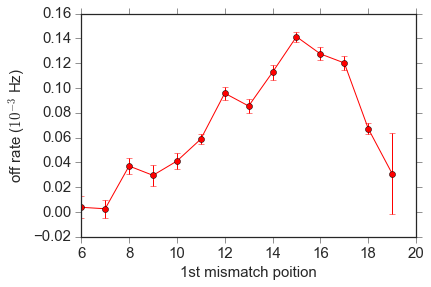

In [16]:
x = np.array(data_2MM['1st_MM_pos'])
y = np.array(data_2MM['off_rate ($10^{-3}$ Hz)'])
err = np.array(data_2MM['se'])
plt.figure(1)
plt.errorbar(x,y, yerr=err, marker='o', color='r')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('off rate ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

# Model for multi-mismatch off-rate

In [6]:
def calc_multiMM_app_offRate(real_offRate, ti=0.5, tf=1.5):
    
    k = real_offRate
    k_off = (np.exp(-k*ti)-np.exp(-k*tf))/(tf-ti)
    return k_off

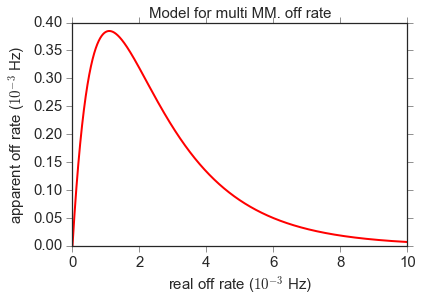

In [17]:
plt.figure(2)
plt.plot(np.arange(0,10,0.001), 
         calc_multiMM_app_offRate(np.arange(0,10,0.001)), 
         color='r',lw=2)
plt.xlabel('real off rate ($10^{-3}$ Hz)', fontsize=15)
plt.ylabel('apparent off rate ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('Model for multi MM. off rate', fontsize=15)

In [40]:
k_opt = minimize(lambda x: -1*calc_multiMM_app_offRate(x),x0=1).x[0]

real_offrate_usol =[]
real_offrate_lsol =[]

for k in y:
    koff_u = brentq(lambda x: calc_multiMM_app_offRate(x)-k,a=k_opt, b=10000)
    koff_l = brentq(lambda x: k-calc_multiMM_app_offRate(x),a=0, b=k_opt)
    real_offrate_usol.append(koff_u)
    real_offrate_lsol.append(koff_l)
    
real_offrate_usol = np.array(real_offrate_usol)
real_offrate_lsol = np.array(real_offrate_lsol)
cross_point = 18
real_offrate = np.copy(real_offrate_usol)
real_offrate[cross_point-20:] = real_offrate_lsol[cross_point-20:]

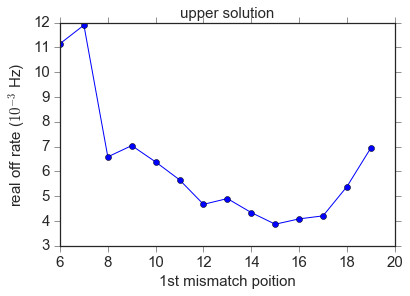

In [41]:
plt.figure(3)
plt.plot(x, real_offrate_usol, marker='o', color='b')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('real off rate ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('upper solution', fontsize=15)

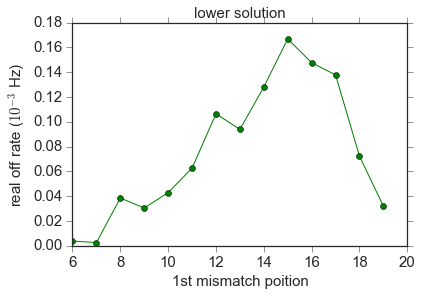

In [42]:
plt.figure(4)
plt.plot(x, real_offrate_lsol, marker='o', color='g')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('real off rate ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('lower solution', fontsize=15)

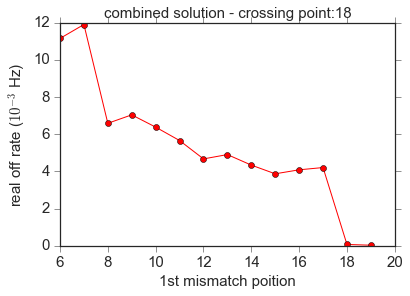

In [43]:
plt.figure(4)
plt.plot(x, real_offrate, marker='o', color='r')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('real off rate ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('combined solution - crossing point:' + str(cross_point), fontsize=15)

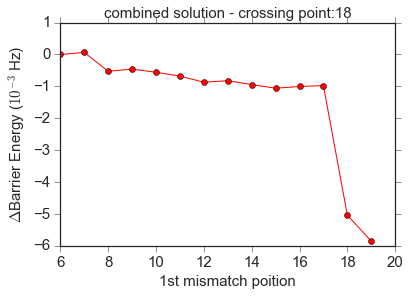

In [44]:
plt.figure(4)
plt.plot(x, np.log(real_offrate/real_offrate[0]), marker='o', color='r')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('$\Delta$Barrier Energy ($10^{-3}$ Hz)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('combined solution - crossing point:' + str(cross_point), fontsize=15)